<a href="https://colab.research.google.com/github/ThierrryScotto/Optuna-XGBoost-hyperparameter/blob/main/Optuna_XGBoost_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn

sns.set()
%config InlineBeckend.figure_formar = 'retina'
warnings.filterwarnings("ignore")

## Loading the boston dataset

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['target']  = boston.target

In [4]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [5]:
X = df.iloc[:, df.columns != 'target']
y = df.target

### Scaling data

In [6]:
from sklearn.preprocessing import StandardScaler
se = StandardScaler()
X = se.fit_transform(X)

### Split data into training and test

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

**Converting the training and test data into xgboost optimized matrix for efficiency**

In [8]:
df_train = xgb.DMatrix(X_train, y_train)
df_test = xgb.DMatrix(X_test, y_test)

### Testing a base model

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit

cv_ = KFold(n_splits=10)
xg_reg = xgb.XGBRFRegressor()
scores = cross_val_score(xg_reg, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv_)

In [10]:
print(np.mean(scores), np.std(scores))
print(scores)

-4.690851864521107 0.9137364320425729
[-4.46876379 -4.44228761 -4.73628169 -5.57790661 -3.89063134 -5.08357565
 -5.49483956 -3.32361937 -6.36116408 -3.52944895]


#### Creating a scoring funtion with the help of XGBOOST train inbuilt early stopping
here we are not tuning the n_estimators with the help of optuna

we will tune the n_estimators with the help of early_stopping by using the xgboost.train

In [11]:
import re
def return_rmse(params):
  model = xgb.train(params, df_train, num_boost_round=600, evals=[(df_test, 'eval')], early_stopping_rounds=20, verbose_eval=0)
  result = model.eval(df_test)
  result = np.float(re.search(r'[\d.]+$', result).group(0))
  print(result)
  return result

#### importing optuna

In [12]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 3.2 MB/s eta 0:00:00


In [13]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [14]:
def objective(trial):
    param = {
                # "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth', 3, 5),
                'reg_alpha':trial.suggest_uniform('reg_alpha', 0, 6),
                'reg_lambda':trial.suggest_uniform('reg_lambda', 0, 2),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.05, 0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.4, 0.9),
                'subsample':trial.suggest_uniform('subsample', 0.4, 0.9),
                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

**calling the optuna study**

In [15]:
stady1 = optuna.create_study(direction='minimize', sampler=TPESampler())
stady1.optimize(objective, n_trials=1050, show_progress_bar=True)

[I 2023-01-19 22:49:39,612] A new study created in memory with name: no-name-51dc4126-e839-401e-8ce4-b15484750977


  0%|          | 0/1050 [00:00<?, ?it/s]

3.561713
[I 2023-01-19 22:49:39,855] Trial 0 finished with value: 3.561713 and parameters: {'max_depth': 4, 'reg_alpha': 3.121546338514949, 'reg_lambda': 1.6714025231423473, 'min_child_weight': 5, 'gamma': 2.612110367198551, 'learning_rate': 0.37520915648187214, 'colsample_bytree': 0.4822416239309747, 'subsample': 0.5143698165741228}. Best is trial 0 with value: 3.561713.
3.506153
[I 2023-01-19 22:49:40,084] Trial 1 finished with value: 3.506153 and parameters: {'max_depth': 4, 'reg_alpha': 0.7459845813000276, 'reg_lambda': 0.16237234853001925, 'min_child_weight': 5, 'gamma': 1.3873113752239785, 'learning_rate': 0.07086309514751737, 'colsample_bytree': 0.8855867711119277, 'subsample': 0.5628746841771619}. Best is trial 1 with value: 3.506153.
3.495151
[I 2023-01-19 22:49:40,200] Trial 2 finished with value: 3.495151 and parameters: {'max_depth': 3, 'reg_alpha': 4.9675721466792355, 'reg_lambda': 0.9147348203328363, 'min_child_weight': 2, 'gamma': 3.6323781369127572, 'learning_rate': 0.1

#### **Printing the best estimators**

In [16]:
return_rmse(stady1.best_params)

2.73325


2.73325

In [17]:
trial = stady1.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 2.73325


In [18]:
stady1.best_params

{'max_depth': 5,
 'reg_alpha': 4.153816912266414,
 'reg_lambda': 0.11399014575557556,
 'min_child_weight': 1,
 'gamma': 0.4574299414565588,
 'learning_rate': 0.14258379202548274,
 'colsample_bytree': 0.7156736596789354,
 'subsample': 0.43248433530805536}

## Without using any hypeparameter tuning

In [19]:
params = {}
print(f"Without tuning {return_rmse(params)}\n")
print(f"With tuning {return_rmse(stady1.best_params)}")

3.214825
Without tuning 3.214825

2.73325
With tuning 2.73325


### Plotting of our search history

In [20]:
optuna.visualization.plot_optimization_history(stady1)

In [21]:
optuna.visualization.plot_slice(stady1)

## Tuning again with more narrower values to get the sweet spot

In [22]:
def objective(trial):
   
    param = {
                # "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth',4,4),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,2),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.5,1),
                'min_child_weight':trial.suggest_int('min_child_weight',1,1),
                'gamma':trial.suggest_int('gamma',1,1),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.2,0.4),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.6),
                'subsample':trial.suggest_uniform('subsample',0.4,0.5),
                'nthread' : -1
             }
    return(return_rmse(param))

**Calling the optuna study**

In [23]:
stady2 = optuna.create_study(direction='minimize', sampler=TPESampler())
stady2.optimize(objective, n_trials=1050, show_progress_bar=True)

[I 2023-01-19 22:55:05,157] A new study created in memory with name: no-name-5fb7d772-d499-457d-a991-6c6a09ab7da6


  0%|          | 0/1050 [00:00<?, ?it/s]

3.196433
[I 2023-01-19 22:55:05,253] Trial 0 finished with value: 3.196433 and parameters: {'max_depth': 4, 'reg_alpha': 0.2078094433657609, 'reg_lambda': 0.6696196773696066, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.24198128088531218, 'colsample_bytree': 0.5357543221167206, 'subsample': 0.4058225584963502}. Best is trial 0 with value: 3.196433.
3.614827
[I 2023-01-19 22:55:05,328] Trial 1 finished with value: 3.614827 and parameters: {'max_depth': 4, 'reg_alpha': 0.36991435994485333, 'reg_lambda': 0.7504254107456529, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.32957519147905273, 'colsample_bytree': 0.47540455124201697, 'subsample': 0.41494804888341336}. Best is trial 0 with value: 3.196433.
3.387509
[I 2023-01-19 22:55:05,460] Trial 2 finished with value: 3.387509 and parameters: {'max_depth': 4, 'reg_alpha': 0.20093570064204758, 'reg_lambda': 0.529839666346335, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.20469607376663176, 'colsample_bytree': 0.4438889

In [24]:
optuna.visualization.plot_optimization_history(stady2)

In [25]:
stady2.best_params

{'max_depth': 4,
 'reg_alpha': 1.9051840999541045,
 'reg_lambda': 0.7018449025650935,
 'min_child_weight': 1,
 'gamma': 1,
 'learning_rate': 0.3251261283346724,
 'colsample_bytree': 0.5182993595037964,
 'subsample': 0.42444864923239184}

In [26]:
params = {}
print(f"withou tuning: {return_rmse(params)}\n")
print(f"With tuning params 1: {return_rmse(stady1.best_params)}\n")
print(f"With tuning params 2: {return_rmse(stady2.best_params)}")

3.214825
withou tuning: 3.214825

2.73325
With tuning params 1: 2.73325

2.57085
With tuning params 2: 2.57085


## Visualising the overfitting and underfitting and finding the best estimators

In [31]:
from sklearn.model_selection import validation_curve

param_range = np.arange(10, 250, 2)

train_scores = []
test_scores = []

for i in param_range:
  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', **stady2.best_params, n_estimators=i)
  xg_reg.fit(X_train, y_train)

  train_scores.append(np.sqrt(mean_squared_error(y_train, xg_reg.predict(X_train))))
  test_scores.append(np.sqrt(mean_squared_error(y_test ,xg_reg.predict(X_test))))

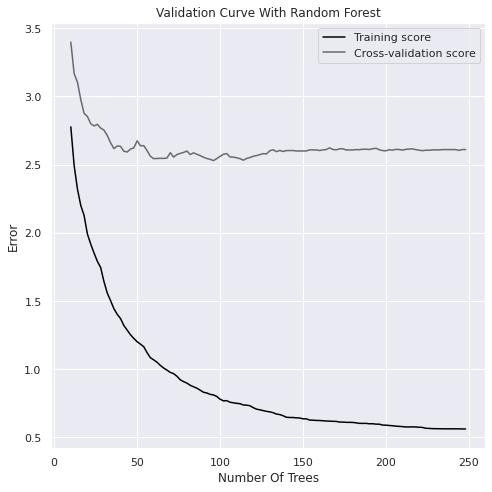

In [32]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_scores, label="Training score", color="black")
plt.plot(param_range, test_scores, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Finding the best n_estimators with the early stopping

In [35]:
model = xgb.train(stady2.best_params, df_train, num_boost_round=600, evals=[(df_test, 'eval')],
                  early_stopping_rounds=20, verbose_eval=1)

[0]	eval-rmse:17.0593
Will train until eval-rmse hasn't improved in 20 rounds.
[1]	eval-rmse:12.055
[2]	eval-rmse:8.99979
[3]	eval-rmse:6.92484
[4]	eval-rmse:5.80068
[5]	eval-rmse:4.85619
[6]	eval-rmse:4.11689
[7]	eval-rmse:3.81215
[8]	eval-rmse:3.57118
[9]	eval-rmse:3.39872
[10]	eval-rmse:3.29065
[11]	eval-rmse:3.16778
[12]	eval-rmse:3.12479
[13]	eval-rmse:3.10526
[14]	eval-rmse:2.98276
[15]	eval-rmse:2.97754
[16]	eval-rmse:2.90103
[17]	eval-rmse:2.87663
[18]	eval-rmse:2.8768
[19]	eval-rmse:2.85284
[20]	eval-rmse:2.86973
[21]	eval-rmse:2.80088
[22]	eval-rmse:2.8265
[23]	eval-rmse:2.78378
[24]	eval-rmse:2.80732
[25]	eval-rmse:2.79566
[26]	eval-rmse:2.82661
[27]	eval-rmse:2.76819
[28]	eval-rmse:2.77838
[29]	eval-rmse:2.75272
[30]	eval-rmse:2.74749
[31]	eval-rmse:2.71341
[32]	eval-rmse:2.68393
[33]	eval-rmse:2.66001
[34]	eval-rmse:2.65153
[35]	eval-rmse:2.6172
[36]	eval-rmse:2.63185
[37]	eval-rmse:2.63701
[38]	eval-rmse:2.63044
[39]	eval-rmse:2.63377
[40]	eval-rmse:2.60007
[41]	eval-rmse

## Final Model

In [41]:
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', **stady2.best_params, n_estimators= 71)
xgb_regressor_base = xgb.XGBRegressor(objective ='reg:squarederror')

In [44]:
xgb_regressor_base.fit(X_train, y_train)
score1 = xgb_regressor_base.score(X_test, y_test)

xgb_regressor.fit(X_train, y_train)
score2 = xgb_regressor.score(X_test, y_test)

print(f"R2 score withouth tuning: {score1}\nR2 score with tuning: {score2}")

R2 score withouth tuning: 0.8646010514688809
R2 score with tuning: 0.9192555820669526
